<a href="https://colab.research.google.com/github/Nard77/CSC173-DeepCV-Dadula/blob/main/Detecting_Accidents_and_Crowd_Events_in_CCTV_Footage_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


CUDA available: True
GPU: Tesla T4


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/My Drive/video_anomaly_project
!pwd
!ls


/content/drive/My Drive/video_anomaly_project
/content/drive/My Drive/video_anomaly_project
cnn_lstm_anomaly.pth  data  demo  result  yolov8n.pt


In [4]:
!pip install opencv-python tqdm


In [5]:
import os
import glob
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import random


class VideoClipDataset(Dataset):
    def __init__(self, root_dir, clip_len=16, resize=(224, 224),
                 mode='train', max_videos=50):
        self.root_dir = root_dir
        self.clip_len = clip_len
        self.resize = resize
        self.mode = mode

        normal_videos = glob.glob(os.path.join(root_dir, 'normal', '*'))
        anom_videos   = glob.glob(os.path.join(root_dir, 'anomalous', '*'))

        # build list of (path, label) and randomly keep up to max_videos
        all_samples = []
        for path in normal_videos:
            all_samples.append((path, 0))
        for path in anom_videos:
            all_samples.append((path, 1))

        random.shuffle(all_samples)
        self.samples = all_samples[:max_videos]

        self.transform = T.Compose([
            T.ToPILImage(),
            T.Resize(resize),
            T.RandomHorizontalFlip(p=0.5 if mode == 'train' else 0.0),
            T.ColorJitter(brightness=0.2, contrast=0.2) if mode == 'train' else T.Lambda(lambda x: x),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.samples)

    def _read_video_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()
        return frames

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = self._read_video_frames(video_path)

        if len(frames) == 0:
            raise RuntimeError(f"No frames in {video_path}")

        if len(frames) < self.clip_len:
            frames = frames * (self.clip_len // len(frames) + 1)

        if self.mode == 'train':
            max_start = max(0, len(frames) - self.clip_len)
            start = random.randint(0, max_start) if max_start > 0 else 0
        else:
            start = max(0, (len(frames) - self.clip_len) // 2)

        clip = frames[start:start + self.clip_len]

        clip_t = []
        for f in clip:
            clip_t.append(self.transform(f))
        clip_t = torch.stack(clip_t, dim=1)  # (C, T, H, W)
        label = torch.tensor(label, dtype=torch.long)
        return clip_t, label


In [6]:
import torch.nn as nn
import torchvision.models as models

class CNNLSTM(nn.Module):
    def __init__(self, feature_dim=512, hidden_dim=256, num_layers=1, num_classes=2):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        modules = list(base.children())[:-1]  # remove FC layer
        self.cnn = nn.Sequential(*modules)
        self.feature_dim = feature_dim

        self.lstm = nn.LSTM(input_size=feature_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (B, C, T, H, W)
        B, C, T, H, W = x.size()
        x = x.permute(0, 2, 1, 3, 4)  # (B, T, C, H, W)
        x = x.reshape(B * T, C, H, W)

        # Pretrained CNN as frozen feature extractor for stability
        with torch.no_grad():
            feats = self.cnn(x)  # (B*T, 512, 1, 1)
        feats = feats.view(B, T, self.feature_dim)  # (B, T, 512)

        out, _ = self.lstm(feats)  # (B, T, H)
        last = out[:, -1, :]       # last time step
        logits = self.fc(last)     # (B, num_classes)
        return logits


In [7]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

clip_len = 8  # you can change to 8 or 32

train_ds = VideoClipDataset('/content/drive/MyDrive/video_anomaly_project/data/training',
                            clip_len=clip_len, mode='train',max_videos=30, )
val_ds   = VideoClipDataset('/content/drive/MyDrive/video_anomaly_project/data/val',
                            clip_len=clip_len, mode='val', max_videos=30,)

print("Train samples:", len(train_ds), "Val samples:", len(val_ds))

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=0)

model = CNNLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss, correct, total = 0.0, 0, 0

    for clips, labels in tqdm(loader, desc='train' if train else 'val'):
        clips, labels = clips.to(device), labels.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            outputs = model(clips)
            loss = criterion(outputs, labels)
            if train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * clips.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


Using device: cuda
Train samples: 30 Val samples: 30


val: 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


Epoch 1/50: train_loss=0.6393, train_acc=0.600, val_loss=0.5290, val_acc=0.900, train_prec=0.591, train_rec=0.812, val_prec=1.000, val_rec=0.800


val: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]


Epoch 2/50: train_loss=0.4849, train_acc=0.700, val_loss=0.5136, val_acc=0.900, train_prec=0.769, train_rec=0.625, val_prec=1.000, val_rec=0.800


val: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


Epoch 3/50: train_loss=0.4598, train_acc=0.867, val_loss=0.5211, val_acc=0.867, train_prec=0.833, train_rec=0.938, val_prec=1.000, val_rec=0.733


val: 100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


Epoch 4/50: train_loss=0.5633, train_acc=0.667, val_loss=0.5326, val_acc=0.833, train_prec=0.750, train_rec=0.562, val_prec=1.000, val_rec=0.667


val: 100%|██████████| 15/15 [00:19<00:00,  1.33s/it]


Epoch 5/50: train_loss=0.6031, train_acc=0.700, val_loss=0.5099, val_acc=0.833, train_prec=0.706, train_rec=0.750, val_prec=0.857, val_rec=0.800


val: 100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


Epoch 6/50: train_loss=0.3988, train_acc=0.867, val_loss=0.5255, val_acc=0.867, train_prec=0.833, train_rec=0.938, val_prec=1.000, val_rec=0.733


val: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Epoch 7/50: train_loss=0.5330, train_acc=0.700, val_loss=0.5492, val_acc=0.733, train_prec=0.733, train_rec=0.688, val_prec=1.000, val_rec=0.467


val: 100%|██████████| 15/15 [00:19<00:00,  1.27s/it]


Epoch 8/50: train_loss=0.4998, train_acc=0.733, val_loss=0.5146, val_acc=0.900, train_prec=0.722, train_rec=0.812, val_prec=1.000, val_rec=0.800


val: 100%|██████████| 15/15 [00:18<00:00,  1.21s/it]


Epoch 9/50: train_loss=0.4548, train_acc=0.800, val_loss=0.5370, val_acc=0.867, train_prec=0.750, train_rec=0.938, val_prec=1.000, val_rec=0.733


val: 100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


Epoch 10/50: train_loss=0.4137, train_acc=0.767, val_loss=0.5307, val_acc=0.900, train_prec=0.846, train_rec=0.688, val_prec=1.000, val_rec=0.800


val: 100%|██████████| 15/15 [00:19<00:00,  1.32s/it]


Epoch 11/50: train_loss=0.5486, train_acc=0.700, val_loss=0.5201, val_acc=0.900, train_prec=0.667, train_rec=0.875, val_prec=1.000, val_rec=0.800


val: 100%|██████████| 15/15 [00:18<00:00,  1.26s/it]


Epoch 12/50: train_loss=0.4464, train_acc=0.733, val_loss=0.5538, val_acc=0.867, train_prec=0.750, train_rec=0.750, val_prec=0.923, val_rec=0.800


val: 100%|██████████| 15/15 [00:18<00:00,  1.24s/it]


Epoch 13/50: train_loss=0.4241, train_acc=0.800, val_loss=0.5564, val_acc=0.767, train_prec=0.750, train_rec=0.938, val_prec=0.786, val_rec=0.733


val: 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


Epoch 14/50: train_loss=0.5404, train_acc=0.700, val_loss=0.5481, val_acc=0.800, train_prec=0.769, train_rec=0.625, val_prec=0.909, val_rec=0.667


val: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


Epoch 15/50: train_loss=0.5174, train_acc=0.767, val_loss=0.5356, val_acc=0.767, train_prec=0.696, train_rec=1.000, val_prec=0.750, val_rec=0.800


val: 100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


Epoch 16/50: train_loss=0.4548, train_acc=0.700, val_loss=0.5318, val_acc=0.800, train_prec=0.818, train_rec=0.562, val_prec=1.000, val_rec=0.600


val: 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]


Epoch 17/50: train_loss=0.4341, train_acc=0.833, val_loss=0.5124, val_acc=0.833, train_prec=0.762, train_rec=1.000, val_prec=0.857, val_rec=0.800


val: 100%|██████████| 15/15 [00:18<00:00,  1.25s/it]


Epoch 18/50: train_loss=0.4353, train_acc=0.767, val_loss=0.5068, val_acc=0.867, train_prec=0.800, train_rec=0.750, val_prec=1.000, val_rec=0.733


val: 100%|██████████| 15/15 [00:19<00:00,  1.31s/it]


Epoch 19/50: train_loss=0.4405, train_acc=0.767, val_loss=0.5020, val_acc=0.867, train_prec=0.846, train_rec=0.688, val_prec=1.000, val_rec=0.733


val: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


Epoch 20/50: train_loss=0.2844, train_acc=0.900, val_loss=0.4861, val_acc=0.767, train_prec=0.882, train_rec=0.938, val_prec=0.750, val_rec=0.800


val: 100%|██████████| 15/15 [00:20<00:00,  1.34s/it]


Epoch 21/50: train_loss=0.3804, train_acc=0.833, val_loss=0.5275, val_acc=0.800, train_prec=0.824, train_rec=0.875, val_prec=1.000, val_rec=0.600


val: 100%|██████████| 15/15 [00:18<00:00,  1.20s/it]


Epoch 22/50: train_loss=0.4129, train_acc=0.800, val_loss=0.4697, val_acc=0.733, train_prec=0.778, train_rec=0.875, val_prec=0.733, val_rec=0.733


val: 100%|██████████| 15/15 [00:19<00:00,  1.33s/it]


Epoch 23/50: train_loss=0.4366, train_acc=0.700, val_loss=0.5191, val_acc=0.833, train_prec=0.733, train_rec=0.688, val_prec=1.000, val_rec=0.667


val: 100%|██████████| 15/15 [00:19<00:00,  1.31s/it]


Epoch 24/50: train_loss=0.4656, train_acc=0.733, val_loss=0.5138, val_acc=0.833, train_prec=0.700, train_rec=0.875, val_prec=1.000, val_rec=0.667


val: 100%|██████████| 15/15 [00:19<00:00,  1.33s/it]


Epoch 25/50: train_loss=0.5249, train_acc=0.700, val_loss=0.4680, val_acc=0.767, train_prec=0.706, train_rec=0.750, val_prec=0.722, val_rec=0.867


val: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Epoch 26/50: train_loss=0.5984, train_acc=0.567, val_loss=0.5113, val_acc=0.833, train_prec=0.636, train_rec=0.438, val_prec=1.000, val_rec=0.667


val: 100%|██████████| 15/15 [00:19<00:00,  1.27s/it]


Epoch 27/50: train_loss=0.4182, train_acc=0.833, val_loss=0.4979, val_acc=0.733, train_prec=0.762, train_rec=1.000, val_prec=0.706, val_rec=0.800


val: 100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


Epoch 28/50: train_loss=0.3616, train_acc=0.867, val_loss=0.5038, val_acc=0.867, train_prec=0.929, train_rec=0.812, val_prec=1.000, val_rec=0.733


val: 100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


Epoch 29/50: train_loss=0.4034, train_acc=0.800, val_loss=0.5245, val_acc=0.767, train_prec=0.778, train_rec=0.875, val_prec=0.900, val_rec=0.600


val: 100%|██████████| 15/15 [00:18<00:00,  1.24s/it]


Epoch 30/50: train_loss=0.1293, train_acc=1.000, val_loss=0.5125, val_acc=0.767, train_prec=1.000, train_rec=1.000, val_prec=0.750, val_rec=0.800


val: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]


Epoch 31/50: train_loss=0.4634, train_acc=0.767, val_loss=0.5761, val_acc=0.767, train_prec=0.765, train_rec=0.812, val_prec=1.000, val_rec=0.533


val: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


Epoch 32/50: train_loss=0.2878, train_acc=0.833, val_loss=0.4978, val_acc=0.733, train_prec=0.867, train_rec=0.812, val_prec=0.769, val_rec=0.667


val: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


Epoch 33/50: train_loss=0.3374, train_acc=0.833, val_loss=0.4724, val_acc=0.800, train_prec=0.762, train_rec=1.000, val_prec=0.846, val_rec=0.733


val: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Epoch 34/50: train_loss=0.1741, train_acc=0.967, val_loss=0.5113, val_acc=0.800, train_prec=1.000, train_rec=0.938, val_prec=1.000, val_rec=0.600


val: 100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


Epoch 35/50: train_loss=0.4059, train_acc=0.733, val_loss=0.5035, val_acc=0.833, train_prec=0.722, train_rec=0.812, val_prec=1.000, val_rec=0.667


val: 100%|██████████| 15/15 [00:18<00:00,  1.24s/it]


Epoch 36/50: train_loss=0.4183, train_acc=0.767, val_loss=0.5567, val_acc=0.767, train_prec=0.714, train_rec=0.938, val_prec=1.000, val_rec=0.533


val: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


Epoch 37/50: train_loss=0.3590, train_acc=0.833, val_loss=0.4991, val_acc=0.833, train_prec=1.000, train_rec=0.688, val_prec=1.000, val_rec=0.667


val: 100%|██████████| 15/15 [00:18<00:00,  1.25s/it]


Epoch 38/50: train_loss=0.2607, train_acc=0.900, val_loss=0.4461, val_acc=0.900, train_prec=0.842, train_rec=1.000, val_prec=1.000, val_rec=0.800


val: 100%|██████████| 15/15 [00:18<00:00,  1.26s/it]


Epoch 39/50: train_loss=0.2464, train_acc=0.867, val_loss=0.4663, val_acc=0.867, train_prec=0.875, train_rec=0.875, val_prec=1.000, val_rec=0.733


val: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Epoch 40/50: train_loss=0.2180, train_acc=0.867, val_loss=0.4795, val_acc=0.867, train_prec=0.833, train_rec=0.938, val_prec=1.000, val_rec=0.733


val: 100%|██████████| 15/15 [00:18<00:00,  1.23s/it]


Epoch 41/50: train_loss=0.1575, train_acc=0.933, val_loss=0.4747, val_acc=0.900, train_prec=0.938, train_rec=0.938, val_prec=1.000, val_rec=0.800


val: 100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


Epoch 42/50: train_loss=0.3458, train_acc=0.867, val_loss=0.4797, val_acc=0.767, train_prec=0.833, train_rec=0.938, val_prec=0.750, val_rec=0.800


val: 100%|██████████| 15/15 [00:19<00:00,  1.30s/it]


Epoch 43/50: train_loss=0.1629, train_acc=0.967, val_loss=0.6103, val_acc=0.800, train_prec=1.000, train_rec=0.938, val_prec=1.000, val_rec=0.600


val: 100%|██████████| 15/15 [00:19<00:00,  1.31s/it]


Epoch 44/50: train_loss=0.3867, train_acc=0.800, val_loss=0.5173, val_acc=0.600, train_prec=0.857, train_rec=0.750, val_prec=0.571, val_rec=0.800


val: 100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


Epoch 45/50: train_loss=0.2037, train_acc=0.933, val_loss=0.5092, val_acc=0.867, train_prec=0.889, train_rec=1.000, val_prec=1.000, val_rec=0.733


val: 100%|██████████| 15/15 [00:16<00:00,  1.13s/it]


Epoch 46/50: train_loss=0.2023, train_acc=0.867, val_loss=0.4811, val_acc=0.767, train_prec=0.929, train_rec=0.812, val_prec=0.750, val_rec=0.800


val: 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


Epoch 47/50: train_loss=0.4163, train_acc=0.800, val_loss=0.4965, val_acc=0.800, train_prec=0.857, train_rec=0.750, val_prec=0.800, val_rec=0.800


val: 100%|██████████| 15/15 [00:16<00:00,  1.13s/it]


Epoch 48/50: train_loss=0.2571, train_acc=0.933, val_loss=0.5344, val_acc=0.800, train_prec=0.889, train_rec=1.000, val_prec=1.000, val_rec=0.600


val: 100%|██████████| 15/15 [00:18<00:00,  1.25s/it]


Epoch 49/50: train_loss=0.2803, train_acc=0.867, val_loss=0.5297, val_acc=0.833, train_prec=0.800, train_rec=1.000, val_prec=1.000, val_rec=0.667


val: 100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


Epoch 50/50: train_loss=0.2699, train_acc=0.900, val_loss=0.5055, val_acc=0.733, train_prec=1.000, train_rec=0.812, val_prec=0.706, val_rec=0.800
Saved model to: /content/drive/MyDrive/video_anomaly_project/cnn_lstm_anomaly.pth
train_loss: [0.6392545859018962, 0.48490931193033854, 0.45979208648204806, 0.5633352637290955, 0.6030536303917567, 0.3988341768582662, 0.5329766064882279, 0.49980841179688773, 0.4547845671574275, 0.4137228786945343, 0.5485659047961235, 0.4464441950122515, 0.4240876893202464, 0.5403947909673055, 0.5174324527382851, 0.45477358549833297, 0.43412203192710874, 0.43530626197655997, 0.4405331571896871, 0.28435560713211694, 0.3804466118415197, 0.4129318411151568, 0.4365785360336304, 0.46564012914896014, 0.5248600939909617, 0.5984489798545838, 0.4182413915793101, 0.3615525968372822, 0.40341893831888836, 0.12932770363986493, 0.46338601807753244, 0.2878298049171766, 0.3373701029767593, 0.17411513154705366, 0.405879167219003, 0.4183009371161461, 0.35904910614093144, 0.26066

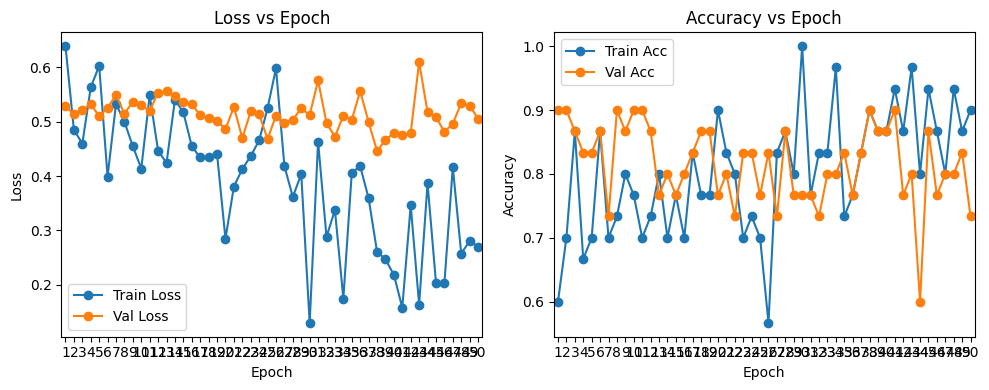

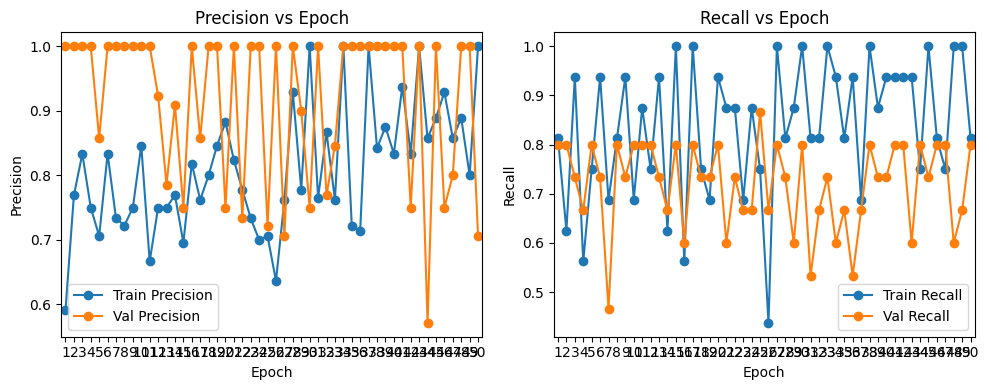

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

num_epochs = 50  # you can increase later

history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'train_precision': [],
    'val_precision': [],
    'train_recall': [],
    'val_recall': [],
}

def run_epoch_with_metrics(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss, correct, total = 0.0, 0, 0
    all_labels = []
    all_preds = []

    for clips, labels in tqdm(loader, desc='train' if train else 'val'):
        clips, labels = clips.to(device), labels.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            outputs = model(clips)
            loss = criterion(outputs, labels)
            if train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * clips.size(0)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.detach().cpu().tolist())
        all_preds.extend(preds.detach().cpu().tolist())

    avg_loss = total_loss / total
    acc = correct / total
    precision = precision_score(all_labels, all_preds, pos_label=1, zero_division=0)
    recall = recall_score(all_labels, all_preds, pos_label=1, zero_division=0)

    return avg_loss, acc, precision, recall

# -------- train loop --------
for epoch in range(num_epochs):
    train_loss, train_acc, train_prec, train_rec = run_epoch_with_metrics(train_loader, train=True)
    val_loss, val_acc, val_prec, val_rec = run_epoch_with_metrics(val_loader, train=False)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['train_precision'].append(train_prec)
    history['val_precision'].append(val_prec)
    history['train_recall'].append(train_rec)
    history['val_recall'].append(val_rec)

    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, '
          f'val_loss={val_loss:.4f}, val_acc={val_acc:.3f}, '
          f'train_prec={train_prec:.3f}, train_rec={train_rec:.3f}, '
          f'val_prec={val_prec:.3f}, val_rec={val_rec:.3f}')

save_path = '/content/drive/MyDrive/video_anomaly_project/cnn_lstm_anomaly.pth'
torch.save(model.state_dict(), save_path)
print("Saved model to:", save_path)

print("train_loss:", history['train_loss'])
print("val_loss:", history['val_loss'])

# -------- plots --------
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], 'o-', label='Train Loss')
plt.plot(epochs, history['val_loss'], 'o-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.xticks(epochs)
plt.xlim(0.5, num_epochs + 0.5)
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history['train_acc'], 'o-', label='Train Acc')
plt.plot(epochs, history['val_acc'], 'o-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.xticks(epochs)
plt.xlim(0.5, num_epochs + 0.5)
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, history['train_precision'], 'o-', label='Train Precision')
plt.plot(epochs, history['val_precision'], 'o-', label='Val Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision vs Epoch')
plt.xticks(epochs)
plt.xlim(0.5, num_epochs + 0.5)
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history['train_recall'], 'o-', label='Train Recall')
plt.plot(epochs, history['val_recall'], 'o-', label='Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall vs Epoch')
plt.xticks(epochs)
plt.xlim(0.5, num_epochs + 0.5)
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
import numpy as np

label_names = ['normal', 'anomalous']

def predict_video(video_path, clip_len=16):
    model.eval()
    ds_tmp = VideoClipDataset('/content/drive/MyDrive/video_anomaly_project/data/val',
                              clip_len=clip_len, mode='val')
    frames = ds_tmp._read_video_frames(video_path)
    if len(frames) == 0:
        print("No frames read from video:", video_path)
        return

    if len(frames) < clip_len:
        frames = frames * (clip_len // len(frames) + 1)

    start = max(0, (len(frames) - clip_len) // 2)
    clip = frames[start:start + clip_len]

    clip_t = []
    for f in clip:
        clip_t.append(ds_tmp.transform(f))
    clip_t = torch.stack(clip_t, dim=1).unsqueeze(0).to(device)  # (1, C, T, H, W)

    with torch.no_grad():
        logits = model(clip_t)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred = int(np.argmax(probs))

    print(f'Prediction for {os.path.basename(video_path)}: '
          f'{label_names[pred]} (p={probs[pred]:.3f})')


In [31]:
!pip install -q ultralytics opencv-python

import math
import cv2
from ultralytics import YOLO

# load YOLO model
yolo = YOLO("yolov8n.pt")   # or your custom weights


def annotate_with_yolo_event_only(
    src_video,
    dst_video,
    conf=0.25
):
    cap = cv2.VideoCapture(src_video)
    if not cap.isOpened():
        print("Failed to open video:", src_video)
        return

    fps = cap.get(cv2.CAP_PROP_FPS) or 15
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(dst_video, fourcc, fps, (w, h))

    event_label = None
    frame_idx = 0

    # thresholds
    CAR_DIST_THRESH = 20          # pixels: how close cars must be
    SPEED_THRESH = 50.0           # pixels per frame: how fast people must move
    MIN_PEOPLE_FOR_STAMPEDE = 20  # people count

    # to approximate speed of persons
    prev_person_centers = None

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1

        results = yolo(frame, conf=conf)[0]
        boxes = results.boxes
        names = results.names

        persons_centers = []
        cars_centers = []

        for b in boxes:
            cls_id = int(b.cls[0].item())
            cls_name = names[cls_id]

            x1, y1, x2, y2 = map(int, b.xyxy[0].tolist())
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2

            if cls_name == 'person':
                persons_centers.append((cx, cy))
            if cls_name in ['car', 'truck', 'bus', 'motorbike']:
                cars_centers.append((cx, cy))

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, cls_name, (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        num_person = len(persons_centers)
        num_car = len(cars_centers)

        # ---- stampede: many people + high speed ----
        is_stampede = False
        if num_person >= MIN_PEOPLE_FOR_STAMPEDE and prev_person_centers is not None:
            # compute approximate speed by matching current centers to previous centers by index
            # (simple heuristic; better would use tracking IDs)
            speeds = []
            for (cx, cy), (px, py) in zip(persons_centers, prev_person_centers):
                dist = math.hypot(cx - px, cy - py)
                speeds.append(dist)
            if speeds:
                fast_count = sum(1 for s in speeds if s >= SPEED_THRESH)
                # require majority of people to be fast
                if fast_count >= MIN_PEOPLE_FOR_STAMPEDE // 2:
                    is_stampede = True

        # ---- car crash: two cars very close ----
        is_car_crash = False
        if num_car >= 2:
            for i in range(num_car):
                for j in range(i + 1, num_car):
                    x1, y1 = cars_centers[i]
                    x2, y2 = cars_centers[j]
                    dist = math.hypot(x1 - x2, y1 - y2)
                    if dist < CAR_DIST_THRESH:
                        is_car_crash = True
                        break
                if is_car_crash:
                    break

        # keep centers for next frame (for speed)
        prev_person_centers = persons_centers

        # set event_label once when a rule first fires
        if event_label is None:
            if is_stampede:
                event_label = "stampede"
            elif is_car_crash:
                event_label = "car crash"

        # prediction: anomalous vs normal (rule-based)
        pred_label = "anomalous" if event_label is not None else "normal"

        # build label text
        if event_label is not None:
            global_text = f"{pred_label} | Anomaly: {event_label}"
            global_color = (0, 0, 255)
        else:
            global_text = f"{pred_label} (no YOLO event)"
            global_color = (0, 255, 0)

        cv2.putText(frame, global_text, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, global_color, 2)

        out.write(frame)

    cap.release()
    out.release()
    print("Final event_label:", event_label)
    print("Saved annotated video to:", dst_video)

src_video = '/content/drive/MyDrive/video_anomaly_project/data/val/anomalous/carcollision.mp4'
dst_video = '/content/drive/MyDrive/video_anomaly_project/result/result_carcollision1.mp4'

annotate_with_yolo_event_only(src_video, dst_video, conf=0.25)


0: 384x640 10 cars, 4 traffic lights, 23.4ms
Speed: 3.5ms preprocess, 23.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 4 traffic lights, 10.0ms
Speed: 2.7ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 4 traffic lights, 10.7ms
Speed: 3.9ms preprocess, 10.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 4 traffic lights, 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 5 traffic lights, 11.2ms
Speed: 5.1ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 4 traffic lights, 12.1ms
Speed: 2.6ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 4 traffic lights, 11.9ms
Speed: 4.6ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

